# Setup

In [1]:
%load_ext autoreload
%autoreload 2
%aimport

Modules to reload:
all-except-skipped

Modules to skip:



In [2]:
%matplotlib inline

In [3]:
import warnings
from matplotlib import rc
rc('text', usetex=True)
warnings.filterwarnings('ignore')

In [25]:
import astropy
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt 
import re 
from astropy.table import Table
import astropy.table
import json
from scipy import stats
from copy import deepcopy

import warnings

import matplotlib as mpl


In [30]:
mpl.rcParams.update(
{
    # figure
    'figure.figsize':   (10, 10),
    
    # axes
    'axes.labelsize': 24,
    
    # title
    'axes.titlesize':28,
    
    # ticks
    'xtick.major.size':  5,
    'xtick.minor.size':  2.5,
    'xtick.major.width': 0.8,
    'xtick.minor.width': 0.6,
    'xtick.labelsize':   20,
    
    'ytick.major.size':  5,
    'ytick.minor.size':  2.5,
    'ytick.major.width': 0.8,
    'ytick.minor.width': 0.6,
    'ytick.labelsize':   20,
    
    #legend
    'legend.fontsize': 24,

})

# Load data

In [5]:
from relaxed.analysis import setup, get_am

In [6]:
# catalog
hcat, indices, scales = setup('m11', path='../temp')

In [7]:
# obtain a_m
am, mass_bins = get_am('m11', min_mass=0.1, path='../temp')

# Histogram of NaNs

## m11

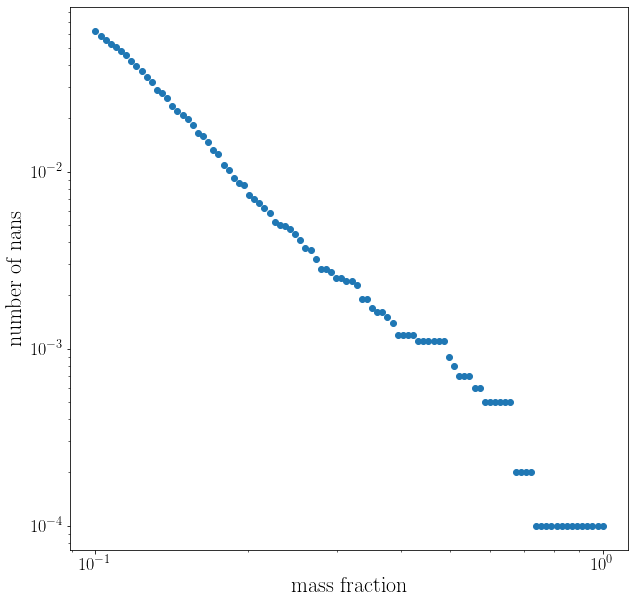

In [120]:
plt.figure(figsize=(10,10))
count_nans = np.array([ (sum(np.isnan(am[:, i]))+1)/(9999-sum(np.isnan(am[:,i]))) for i in range(len(mass_bins))])
plt.scatter(mass_bins, count_nans)
plt.xlabel('\\rm mass fraction', size=22)
plt.ylabel('\\rm number of nans', size=22)
plt.xscale('log')
plt.yscale('log')
plt.tick_params(labelsize=18)
plt.show()

## m12

In [65]:
hcat_12, indices, scales = setup('m12', path='../temp')
am_12, mass_bins_12 = get_am('m12', min_mass=0.1, path='../temp')

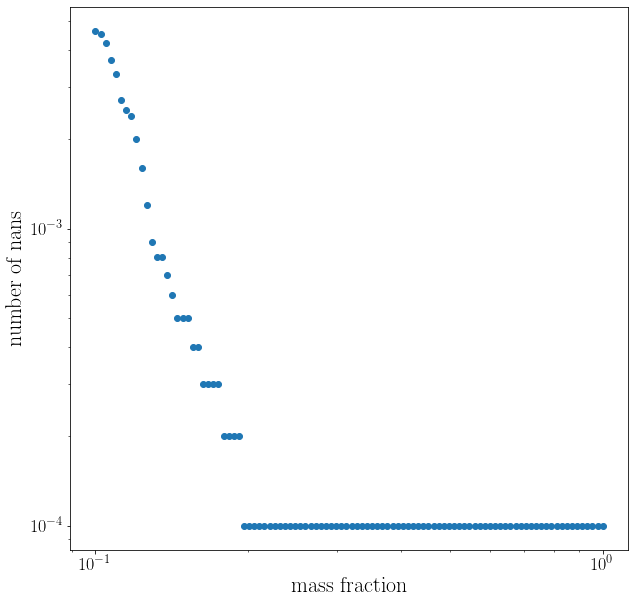

In [66]:
plt.figure(figsize=(10,10))
count_nans = np.array([ (sum(np.isnan(am_12[:, i]))+1)/(9999-sum(np.isnan(am_12[:,i]))) for i in range(len(mass_bins_12))])
plt.scatter(mass_bins_12, count_nans)
plt.xlabel('\\rm mass fraction', size=22)
plt.ylabel('\\rm number of nans', size=22)
plt.xscale('log')
plt.yscale('log')
plt.tick_params(labelsize=18)
plt.show()

# Test normality (with probplots)

## Example of normal distribution

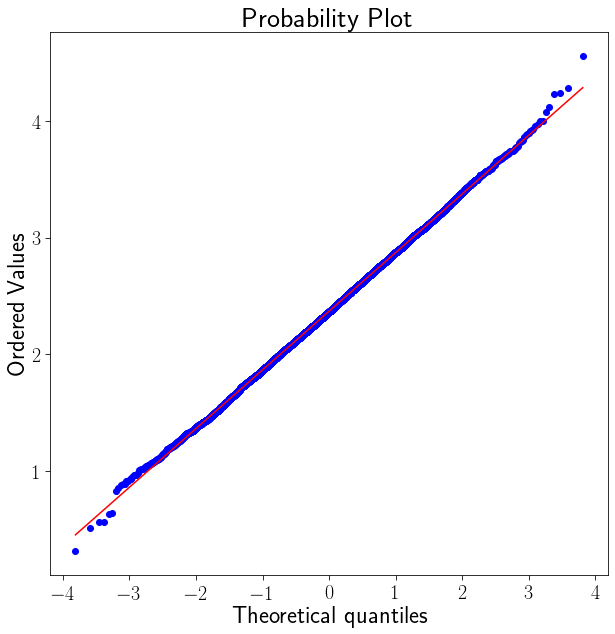

In [64]:
from scipy import stats

x = np.random.randn(10000)*np.std(np.log(cvir)) + np.mean(np.log(cvir))
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
res = stats.probplot(x, dist='norm', plot=ax)



## log c_vir

In [41]:
# use a normaltest to check (H0 = is Gaussian, H1 = not Gaussian)
from scipy.stats import normaltest
k2, p = normaltest(np.log(cvir))
alpha = 1e-3
print(f'cannot reject null hypothesis' if alpha < p else 'reject null hypothesis')
print('p-value:', p)

reject null hypothesis
p-value: 2.2259140416470982e-130


Text(0.5, 1.0, 'Probability Plot for $\\log c_{\\rm vir}$')

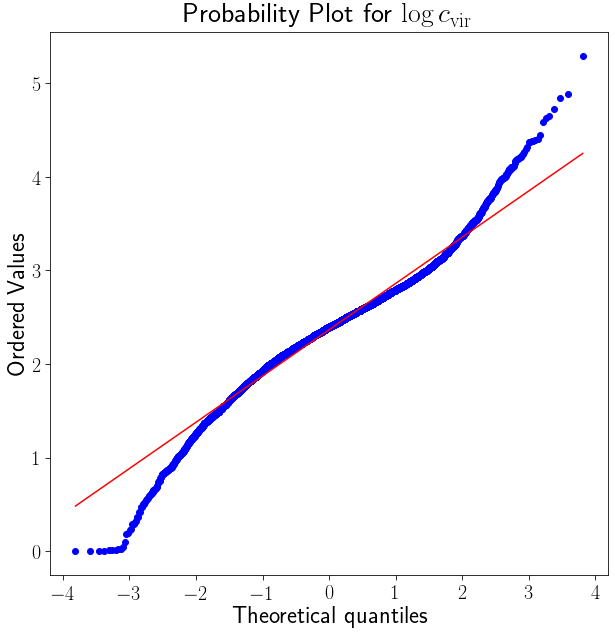

In [35]:
from scipy import stats

x = np.log(cvir)
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
res = stats.probplot(x, dist='norm', plot=ax)
ax.set_title(r"Probability Plot for $\log c_{\rm vir}$")

# close enough!

## a_m_i

(array([1.000e+00, 0.000e+00, 1.000e+00, 5.000e+00, 1.600e+01, 4.500e+01,
        2.330e+02, 1.263e+03, 4.386e+03, 3.720e+03]),
 array([-1.64248733, -1.41437381, -1.18626029, -0.95814677, -0.73003325,
        -0.50191973, -0.27380621, -0.04569269,  0.18242082,  0.41053434,
         0.63864786]),
 <a list of 10 Patch objects>)

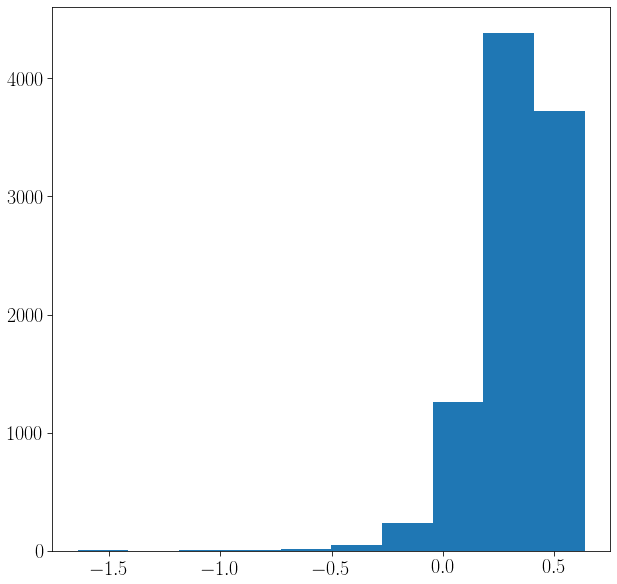

In [69]:
plt.hist(x)

In [92]:
mass_bins[85]

0.7220809018385465

9670


Text(0.5, 1.0, 'Probability Plot for $a(m_i=0.13)$')

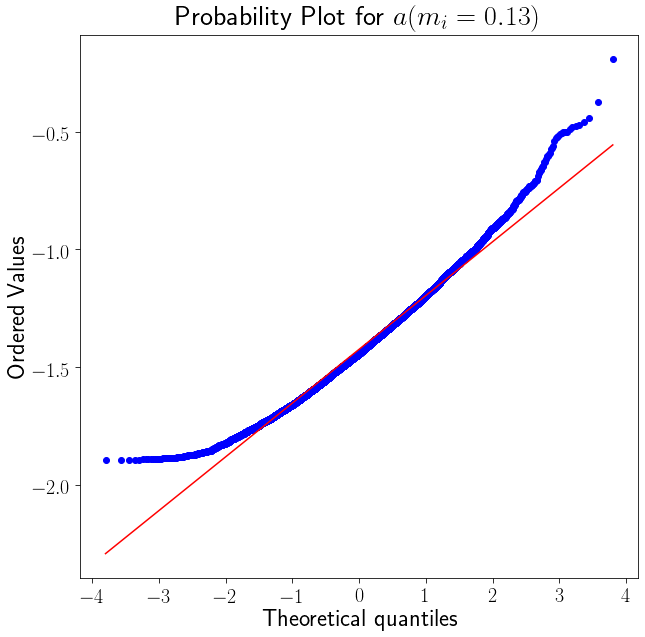

In [105]:

from scipy import stats
idx = 10
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
x = np.log(am[:, idx])
m= mass_bins[idx]
keep = ~np.isnan(x)
x = x[keep]
print(sum(keep))
res = stats.probplot(x, dist='norm', plot=ax, fit=True)
ax.set_title(f"Probability Plot for $a(m_i={m:.2f})$")


# becomes more non-Gaussian as m_i -> 0 or m_i -> 1 

In [83]:
m

nan

# Correlations between a_m(i)

In [56]:
from scipy.stats import spearmanr
n_mbins = 100
corrs = np.zeros((n_mbins, n_mbins))
for i in range(n_mbins):
    for j in range(n_mbins):
        corrs[i,j] = spearmanr(am[:,i], am[:, j], nan_policy='omit')[0]

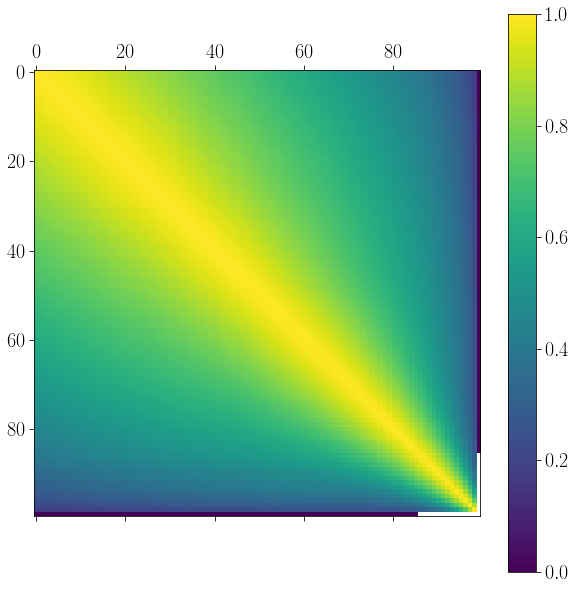

In [61]:
plt.matshow(corrs)
plt.colorbar()

In [122]:
mass_bins

array([0.1       , 0.1023531 , 0.10476158, 0.10722672, 0.10974988,
       0.1123324 , 0.1149757 , 0.1176812 , 0.12045035, 0.12328467,
       0.12618569, 0.12915497, 0.13219411, 0.13530478, 0.13848864,
       0.14174742, 0.14508288, 0.14849683, 0.15199111, 0.15556761,
       0.15922828, 0.16297508, 0.16681005, 0.17073526, 0.17475284,
       0.17886495, 0.18307383, 0.18738174, 0.19179103, 0.19630407,
       0.2009233 , 0.20565123, 0.21049041, 0.21544347, 0.22051307,
       0.22570197, 0.23101297, 0.23644894, 0.24201283, 0.24770764,
       0.25353645, 0.25950242, 0.26560878, 0.27185882, 0.27825594,
       0.28480359, 0.29150531, 0.29836472, 0.30538555, 0.31257158,
       0.31992671, 0.32745492, 0.33516027, 0.34304693, 0.35111917,
       0.35938137, 0.36783798, 0.37649358, 0.38535286, 0.39442061,
       0.40370173, 0.41320124, 0.42292429, 0.43287613, 0.44306215,
       0.45348785, 0.46415888, 0.47508102, 0.48626016, 0.49770236,
       0.5094138 , 0.52140083, 0.53366992, 0.54622772, 0.55908

# Algorithm

In [112]:
am.shape

(9999, 100)

In [120]:
z[:, 0]

array([67.35953522,  8.99742794,  8.37188816, ...,  1.21887195,
       12.45788002,  9.20492744])

In [119]:
z = np.concatenate([cvir.reshape(1, 9999), am.T], axis=0).T
z.shape

(9999, 101)

In [8]:
from scipy import stats
from scipy.stats import spearmanr


def get_quantiles(arr):
    return np.vectorize(lambda x: stats.percentileofscore(arr, x))(arr) / 100.

In [ ]:
def gaussian_conditional(x, am):
    # x represents one of the dark matter halo properties at z=0. 
    # x and log(am) is assumed to be Gaussian. 
    assert len(x.shape)==1
    assert am.shape == (x.shape[0], 100)
    
    # calculate sigma/correlation matrix bewteen all quantitie
    sigma = np.zeros((1 + 100, 1 + 100))
    z = np.concatenate([x.reshape(1, -1), am.T], axis=0).T
    assert z.shape == (x.shape[0], 101)
    
    # calculate covariances
    lam = np.log(am)
    keeps = [~np.isnan(lam[:, i]) for i in range(100)]
    covs = np.zeros((101, 101))
    for i in range(101):
        for j in range(101):
            if i == j == 0:
                covs[0, 0] = np.cov(z[0], z[0])
            if i == 


1. We start by obtaining the rank of both $c_{\rm vir}$ and $a(m)$ for each $m$.

In [9]:
cvir = hcat.cat['cvir']
r_cvir = get_quantiles(cvir)

r_am = [] 
for i in range(am.shape[1]):
    am_i = am[:, i]
    r_am_i = get_quantiles(am_i)
    r_am.append(r_am_i)
r_am = np.array(r_am).T

2. Look at some of the marginal distributions of $\log c_{\rm vir}$ and $\log a(m)$ for some values of $m$ to try to transform them to Gaussians.

reject null hypothesis
p-value: 2.2259140416470982e-130


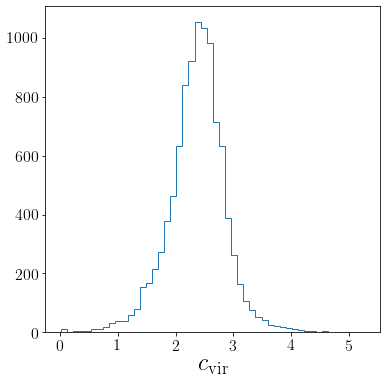

In [13]:
# looks Gaussian already
plt.figure(figsize=(6,6))
plt.hist(np.log(cvir), bins=50, histtype='step');
plt.xlabel("$c_{\\rm vir}$", size=24)
plt.tick_params(which='both', labelsize=16)



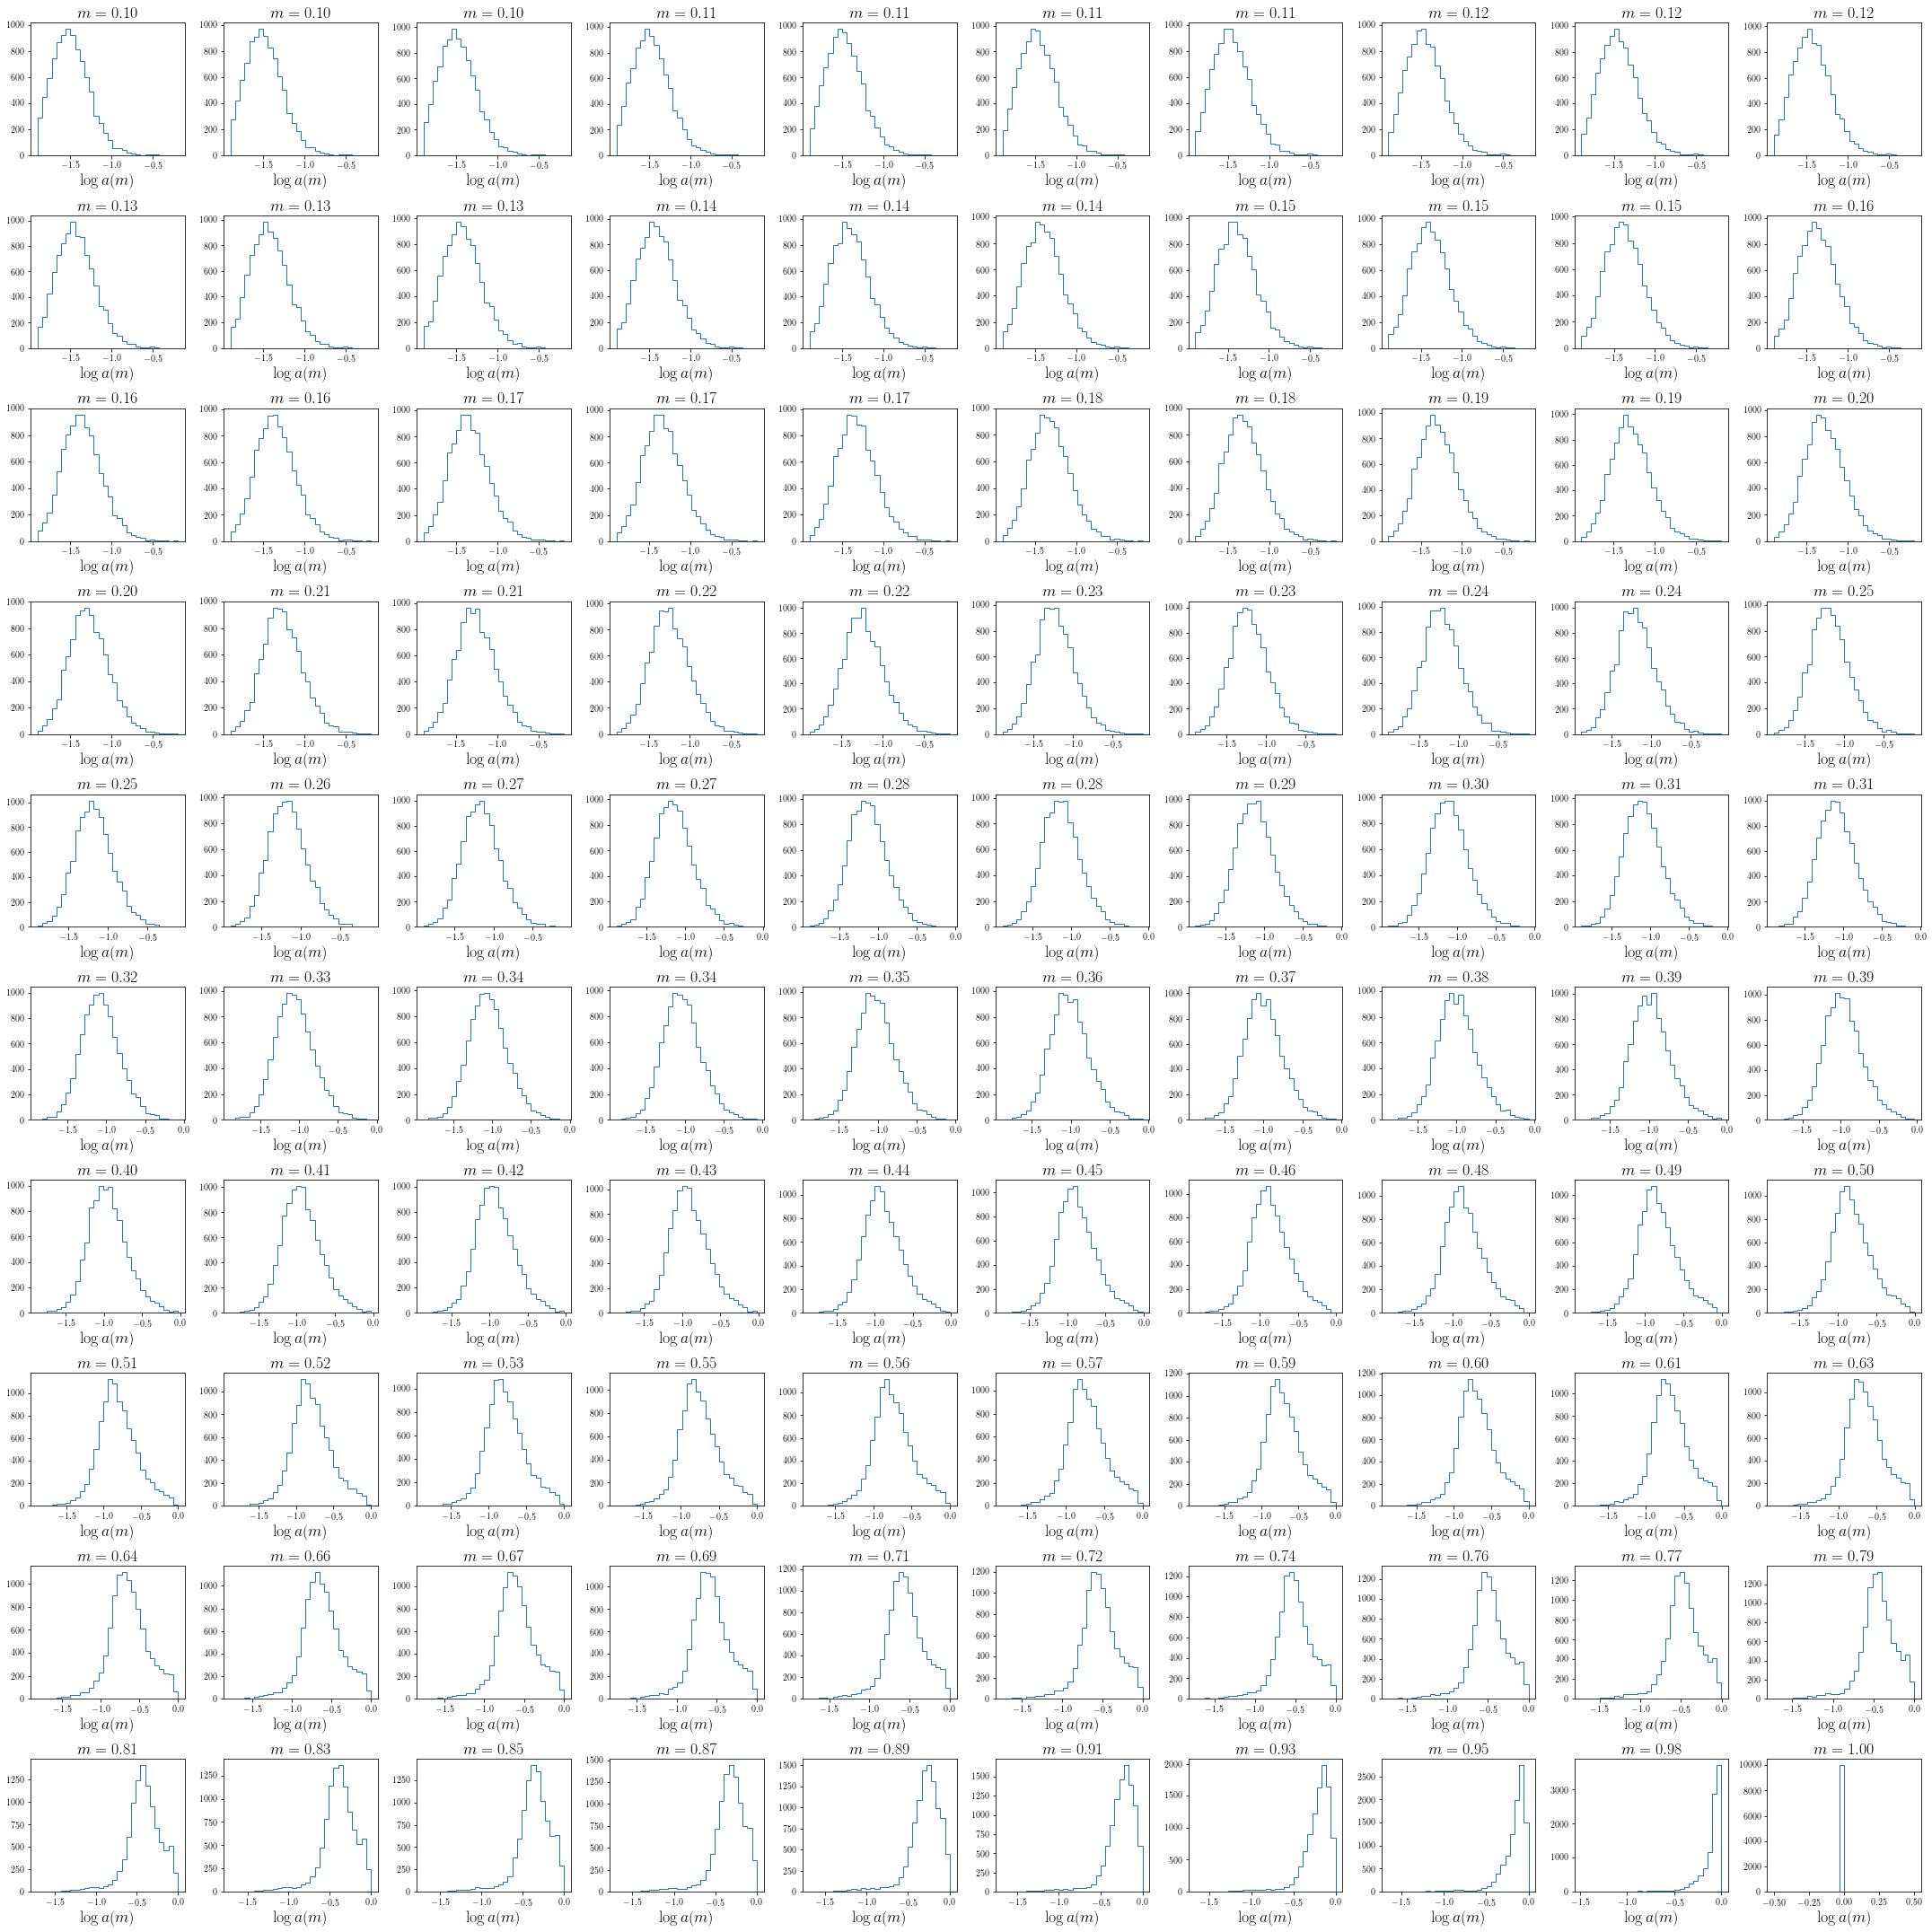

In [150]:
fig, axes = plt.subplots(10, 10, figsize=(30, 30))
axes = axes.flatten()

for i in range(100): 
    ax = axes[i]
    mass_bin = mass_bins[i]
    ax.hist(np.log(am[:, i]), histtype='step', bins=30)
    ax.set_title(f"$m={mass_bin:.2f}$", size=18)
    ax.set_xlabel("$\\log a(m)$", size=18)
plt.tight_layout()

In [107]:
# (2) calculate correlations between r_am and r_cvir:
corrs = [] # one for each am.shape[1] (mass bin)
for i in range(am.shape[1]):
    corrs.append(spearmanr(cvir, am[:, i], nan_policy='omit')[0])
corrs = np.array(corrs)